In [1]:

import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), '..')))
import flares

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmasher as cmr
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from scipy.stats import binned_statistic
from unyt import erg, s

from synthesizer.grid import Grid
from synthesizer.emission_models.agn.models import DiscIncidentEmission
from synthesizer.particle import BlackHoles

from flares_utility.stats import weighted_median, binned_weighted_quantile

# Set a random number seed to ensure consistent results
np.random.seed(42)

# set style
plt.style.use('../matplotlibrc.txt')

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39']
['005_z010p000', '006_z009p000', '007_z008p000', '008_z007p000', '009_z006p000', '010_z005p000']
Galaxy
Galaxy/details
Galaxy/details/blackhole_accretion_rate
Galaxy/details/blackhole_accretion_rate/10
Galaxy/details/blackhole_accretion_rate/100
Galaxy/details/blackhole_accretion_rate/20
Galaxy/details/blackhole_accretion_rate/200
Galaxy/details/blackhole_accretion_rate/50
Galaxy/details/blackhole_accretion_rate/instant
Galaxy/details/blackhole_mass
Galaxy/master
Galaxy/master/attenuated_stellar_halpha_ew
Galaxy/master/attenuated_stellar_halpha_luminosity
Galaxy/master/blackhole_accretion_rate
Galaxy/master/blackhole_accretion_rate/instant
Galaxy/master/blackhole_id
Galaxy/master/blackhole_mass
Galaxy/master/intrinsic_stellar_halpha_ew
Galaxy/master

In [2]:
selection_label = r'$\rm M_{\bullet}>10^{6}\ M_{\odot}, L_{\rm bol}>10^{44}\ {\rm erg\ s^{-1}}$'
conservative_selection_label = r'$\rm M_{\bullet}>10^{7}\ M_{\odot}, L_{\rm bol}>10^{45}\ {\rm erg\ s^{-1}}$'

## get data

In [3]:
grid_name = 'qsosed-isotropic'
grid_dir = "/Users/sw376/Dropbox/Research/data/synthesizer/grids/"

grid = Grid(
    grid_name=grid_name, 
    grid_dir=grid_dir,
    read_lines=False)

In [4]:

def get_quantities(tag):

    quantities = flares.get_quantities(tag, group='details')

    blackhole_mass = quantities['blackhole_masses'].to('Msun')
    blackhole_accretion_rate = quantities['accretion_rates']['10'].to('Msun/yr')
    bolometric_luminosity = quantities['bolometric_luminosities']['10']
    eddington_ratio = quantities['eddington_ratios']['10']
    weights = quantities['weights']

    stellar_halpha_luminosity = quantities['attenuated_stellar_halpha_luminosity'] * erg/s
    intrinsic_stellar_halpha_luminosity = quantities['intrinsic_stellar_halpha_luminosity'] * erg/s


    # print(blackhole_mass)
    print('total number of BHs', len(blackhole_mass))

    selection = (blackhole_mass.to('Msun').value > 1E6) & (bolometric_luminosity.to('erg/s').value > 1E44)

    selection = bolometric_luminosity.to('erg/s').value > 1E30

    print(np.sum(selection))

    stellar_halpha_luminosity = stellar_halpha_luminosity[selection]
    intrinsic_stellar_halpha_luminosity = intrinsic_stellar_halpha_luminosity[selection]
    blackhole_mass = blackhole_mass[selection]
    blackhole_accretion_rate = blackhole_accretion_rate[selection]
    bolometric_luminosity = bolometric_luminosity[selection]
    weights = weights[selection]

    conservative_selection = (blackhole_mass.to('Msun').value > 1E7) & (bolometric_luminosity.to('erg/s').value > 1E45)

    print(np.sum(conservative_selection))

    # initialise blackhole object
    blackholes = BlackHoles(
        masses=blackhole_mass,
        accretion_rates=blackhole_accretion_rate,
    )

    # initialise the emission model
    emission_model = DiscIncidentEmission(grid)

    # get the spectra assuming this emission model
    blackholes.get_particle_spectra(emission_model)

    spectra = blackholes.particle_spectra['disc_incident']

    ionising_photon_luminosity = spectra.calculate_ionising_photon_production_rate()

    ionising_bolometric_correction = ionising_photon_luminosity/spectra.bolometric_luminosity

    halpha_luminosity = ionising_photon_luminosity * flares.ionising_to_Halpha_conversion

    return blackhole_mass, blackhole_accretion_rate, bolometric_luminosity, weights, ionising_photon_luminosity, halpha_luminosity, conservative_selection, stellar_halpha_luminosity, intrinsic_stellar_halpha_luminosity



# def get_quantities(tag):

#     # get data
#     blackhole_mass, blackhole_accretion_rate, bolometric_luminosity, eddington_ratio, weights = u.load_all_blackhole_data(tag=tag)

#     selection = (blackhole_mass.to('Msun').value > 1E6) & (bolometric_luminosity.to('erg/s').value > 1E44)
#     # selection = bolometric_luminosity.to('erg/s').value > 1E30

#     blackhole_mass = blackhole_mass[selection]
#     blackhole_accretion_rate = blackhole_accretion_rate[selection]
#     bolometric_luminosity = bolometric_luminosity[selection]
#     weights = weights[selection]

#     conservative_selection = (blackhole_mass.to('Msun').value > 1E7) & (bolometric_luminosity.to('erg/s').value > 1E45)

#     print(tag, np.sum(selection), np.sum(conservative_selection))

#     selection_label = r'$\rm M_{\bullet}>10^{6}\ M_{\odot}, L_{\rm bol}>10^{44}\ {\rm erg\ s^{-1}}$'
#     conservative_selection_label = r'$\rm M_{\bullet}>10^{7}\ M_{\odot}, L_{\rm bol}>10^{45}\ {\rm erg\ s^{-1}}$'

#     # initialise blackhole object
#     blackholes = BlackHoles(
#         masses=blackhole_mass,
#         accretion_rates=blackhole_accretion_rate,
#     )

#     # initialise the emission model
#     emission_model = DiscIncidentEmission(grid)

#     # get the spectra assuming this emission model
#     blackholes.get_particle_spectra(emission_model)

#     spectra = blackholes.particle_spectra['disc_incident']

#     ionising_photon_luminosity = spectra.calculate_ionising_photon_production_rate()

#     ionising_bolometric_correction = ionising_photon_luminosity/spectra.bolometric_luminosity

#     halpha_luminosity = ionising_photon_luminosity * u.ionising_to_Halpha_conversion

#     return blackhole_mass, blackhole_accretion_rate, bolometric_luminosity, weights, ionising_photon_luminosity, halpha_luminosity, conservative_selection



## Ionising photon luminosity function

total number of BHs 124474
4614
40
total number of BHs 177887
5581
86
total number of BHs 237437
6405
153


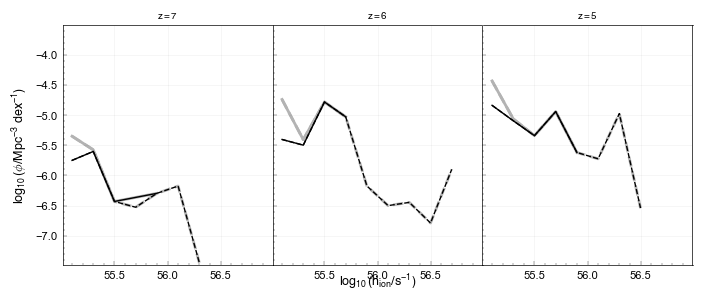

In [5]:

Y_limits = [-7.49, -3.51]
X_limits = [55.01, 56.99]

binw = 0.2
bin_edges = np.arange(55., 57, binw)
bin_centres = bin_edges[:-1]+binw/2


# N = len(flares.redshifts)
# left = 0.075
# top = 0.95
# bottom = 0.15
# right = 0.975
# panel_width = (right-left)/N
# panel_height = top-bottom
# fig, axes = plt.subplots(2, 3, figsize = (7,5), sharey = True, sharex = True)
# plt.subplots_adjust(left=left, top=top, bottom=bottom, right=right, wspace=0.0, hspace=0.1)


N = 3
left = 0.075
top = 0.95
bottom = 0.15
right = 0.975
# panel_width = (right-left)/N
# panel_height = top-bottom
fig, axes = plt.subplots(1, 3, figsize = (7,3.0), sharey = True, sharex = True)
plt.subplots_adjust(left=left, top=top, bottom=bottom, right=right, wspace=0.0, hspace=0.1)


for z, tag, c, ax in zip(flares.redshifts[-3:], flares.tags[-3:], flares.redshift_colours[-3:], axes.flatten()):

    ax.text(0.5, 1.02, rf'$\rm z={z:.0f}$', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize = 7)

    blackhole_mass, blackhole_accretion_rate, bolometric_luminosity, weights, ionising_photon_luminosity, halpha_luminosity, conservative_selection, stellar_halpha_luminosity, intrinsic_stellar_halpha_luminosity = get_quantities(tag=tag)

    # full selection
    x = np.log10(ionising_photon_luminosity.to('1/s').value)

    N, _ = np.histogram(x, bins = bin_edges)
    Nw, _ = np.histogram(x, bins = bin_edges, weights=weights)

    phi = (Nw / flares.volume) / binw

    ax.plot(bin_centres, np.log10(phi), ls ='--', c='0.7', lw=2, zorder=1)
    ax.plot(bin_centres[N>4], np.log10(phi[N>4]), ls = '-', c='0.7', lw=2, zorder=1, label=selection_label)

    # conservative selection
    x = np.log10(ionising_photon_luminosity[conservative_selection].to('1/s').value)

    N, _ = np.histogram(x, bins = bin_edges)
    Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[conservative_selection])

    phi = (Nw / flares.volume) / binw

    ax.plot(bin_centres, np.log10(phi), ls ='--', c='k', lw=1, zorder=2)
    ax.plot(bin_centres[N>4], np.log10(phi[N>4]), ls = '-', c='k', lw=1, zorder=2, label=conservative_selection_label)

    ax.set_xlim(X_limits)
    ax.set_ylim(Y_limits)

fig.text(0.0, bottom+(top-bottom)/2, r'$\rm\log_{10}(\phi/Mpc^{-3}\ dex^{-1})$', rotation = 90, va='center', fontsize = 9)
fig.text(left+(right-left)/2, 0.08, r'$\rm \log_{10}(\dot{n}_{ion}/s^{-1})$', ha='center', fontsize = 9)


# handles = []
# handles.append(Line2D([0], [0], label=r'$\rm stars$', color='0.5', lw=1, alpha=0.5, ls='--', c='k'))
# handles.append(Line2D([0], [0], label=r'$\rm blackholes$', color='0.5', lw=1, alpha=0.5, ls=':', c='k'))
# handles.append(Line2D([0], [0], label=r'$\rm total$', color='0.5', lw=2, alpha=0.5, ls='-', c='k'))

# fig.legend(handles=handles, fontsize=8, labelspacing=0.1, loc = 'outside lower center', ncol=len(handles))

fig.savefig(f'figures/ionising_luminosity_function_evolution.pdf')
plt.show()
fig.clf()

total number of BHs 30945
1362
5
[3 5 4 2 2 1 0 0 0 0 0 0]
total number of BHs 51539
2421
4
[10 13  7  0  1  0  1  2  0  0  0  0]
total number of BHs 82414
3323
18
[29 24 12  9  3  4  2  1  1  0  0  0]
total number of BHs 124474
4614
40
[42 38 27 17  6  5  7  1  2  0  0  2]
total number of BHs 177887
5581
86
[83 67 54 34 21 12  6  4  3  1  2  1]
total number of BHs 237437
6405
153
[126 112  89  52  35  18  12   7   3   4   1   0]


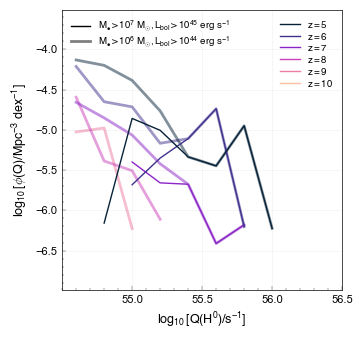

In [6]:
X_limits = [54.5, 56.25]
Y_limits = [-6.99, -3.51]

binw = 0.2
bin_edges = np.arange(54.5, 57, binw)
bin_centres = bin_edges[:-1]+binw/2

fig = plt.figure(figsize = (3.5, 3.5))

left  = 0.15
height = 0.8
bottom = 0.15
width = 0.8

ax = fig.add_axes((left, bottom, width, height))


for z, tag, colour in zip(flares.redshifts, flares.tags, flares.redshift_colours):

    blackhole_mass, blackhole_accretion_rate, bolometric_luminosity, weights, ionising_photon_luminosity, halpha_luminosity, conservative_selection, stellar_halpha_luminosity, intrinsic_stellar_halpha_luminosity = get_quantities(tag=tag)

    # full selection
    x = np.log10(ionising_photon_luminosity.to('1/s').value)

    N, _ = np.histogram(x, bins = bin_edges)
    Nw, _ = np.histogram(x, bins = bin_edges, weights=weights)

    print(N)

    phi = (Nw / flares.volume) / binw

    # ax.plot(bin_centres, np.log10(phi), ls ='--', c=colour, lw=2, zorder=1)
    ax.plot(bin_centres[N>4], np.log10(phi[N>4]), ls = '-', c=colour, lw=2, alpha=0.5, zorder=1)

    # conservative selection
    x = np.log10(ionising_photon_luminosity[conservative_selection].to('1/s').value)

    N, _ = np.histogram(x, bins = bin_edges)
    Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[conservative_selection])

    phi = (Nw / flares.volume) / binw

    # ax.plot(bin_centres, np.log10(phi), ls ='--', c=colour, lw=1, zorder=2)
    ax.plot(bin_centres[N>4], np.log10(phi[N>4]), ls = '-', c=colour, lw=1, zorder=2, label=rf'$\rm z={z:.0f}$')





ax.set_xlim(X_limits)
ax.set_ylim(Y_limits)
ax.set_xticks([55., 55.5, 56.0, 56.5])

ax.set_ylabel(r'$\rm \log_{10}[\phi(Q)/Mpc^{-3}\ dex^{-1}]$')
ax.set_xlabel(r'$\rm \log_{10}[Q(H^0)/s^{-1}]$')

ax.legend(loc='upper right', fontsize=7, labelspacing=0.1)
# handles, labels = ax.get_legend_handles_labels()

handles = []
handles.append(Line2D([0], [0], label=conservative_selection_label, color='k', lw=1, alpha=1.0, ls='-'))
handles.append(Line2D([0], [0], label=selection_label, color='0.5', lw=2, alpha=1.0, ls='-'))
# handles.append(Line2D([0], [0], label=r'$\rm N<5$', color='k', lw=1, alpha=1.0, ls='--'))

# Create a legend for the first line.
first_legend = ax.legend(handles=handles, loc='upper left', fontsize=7, labelspacing=0.1, )

# Add the legend manually to the Axes.
ax.add_artist(first_legend)

# Add main legend
ax.legend(fontsize=7, labelspacing=0.1, loc = 'upper right', reverse=True)

fig.savefig(f'figures/ionising_luminosity_function_evolution.pdf')
plt.show()
fig.clf()

## H-alpha luminosity function

In [14]:

observations = {}

observations[5.0] = {}

# (Matthee+)
observations[5.0]['Matthee+24'] = {}
observations[5.0]['Matthee+24']['log10x'] = np.array([42.5, 42.9, 43.5])
observations[5.0]['Matthee+24']['log10y'] = np.array([-4.2, -4.74, -5.36])
observations[5.0]['Matthee+24']['log10xerr'] = np.array([[0.2, 0.2, 0.4],[0.2, 0.2, 0.4]])
observations[5.0]['Matthee+24']['log10yerr'] = np.array([[0.14, 0.3, 0.53],[0.10, 0.18,0.23]])

observations[5.0]['Lin+24'] = {}
observations[5.0]['Lin+24']['log10x'] = np.array([42.478, 42.911, 43.345])
observations[5.0]['Lin+24']['y'] = np.array([4.04, 1.53, 1.08]) * 1E-5
observations[5.0]['Lin+24']['log10xerr'] = np.array([[0.2165, 0.2165, 0.2165],[0.2165, 0.2165, 0.2165]])
observations[5.0]['Lin+24']['yerr'] = np.array([[-3.12, -1.0, -0.71],[1.60, 0.92, 0.85]]) * 1E-5



def add_observations(redshift, ax=None, add_label=False):

    markers = ['o','s']

    if redshift in observations.keys():

        for study, marker in zip(observations[redshift].keys(), markers):
            ob = observations[redshift][study]

            # if linear y provided convert to log
            if 'log10yerr' not in ob.keys():
                ob['log10y'] = np.log10(ob['y'])

                ob['log10yerr'] = np.array([
                    ob['log10y'] - np.log10(ob['y'] + ob['yerr'][0]),
                    np.log10(ob['y'] + ob['yerr'][1]) - ob['log10y'],
                ])

            print(ob['log10yerr'])

            if add_label:
                label = rf'$\rm {study}$'
            else:
                label = None

            if ax:
                ax.errorbar(ob['log10x'], ob['log10y'], xerr=ob['log10xerr'], yerr=ob['log10yerr'], fmt=marker, c='k', label=label, ms=5)




In [8]:
f_blr = 0.75
f_cov = 0.5

In [9]:
def add_stellar_luminosity_function(ax, tag):

    quantities = flares.get_quantities(tag, group='details')

    # add galaxy H-alpha LF

    stellar_halpha_luminosity = quantities['attenuated_stellar_halpha_luminosity'] * erg/s
    intrinsic_stellar_halpha_luminosity = quantities['intrinsic_stellar_halpha_luminosity'] * erg/s

    # add galaxy H-alpha LF

    x = np.log10(stellar_halpha_luminosity.to('erg/s').value)

    N, _ = np.histogram(x, bins = bin_edges)
    Nw, _ = np.histogram(x, bins = bin_edges, weights=quantities['weights'])

    Nw[Nw==0.0] = 1E-100

    phi = (Nw / flares.volume) / binw

    ax.plot(bin_centres, np.log10(phi), c='k', lw=2, zorder=1, ls='-', alpha=0.1)


    x = np.log10(intrinsic_stellar_halpha_luminosity.to('erg/s').value)

    N, _ = np.histogram(x, bins = bin_edges)
    Nw, _ = np.histogram(x, bins = bin_edges, weights=quantities['weights'])

    Nw[Nw==0.0] = 1E-100

    phi = (Nw / flares.volume) / binw

    ax.plot(bin_centres, np.log10(phi), c='k', lw=2, zorder=1, ls='--', alpha=0.1)

total number of BHs 124474
4614
40
total number of BHs 177887
5581
86
total number of BHs 237437
6405
153
[[0.14 0.3  0.53]
 [0.1  0.18 0.23]]
[[0.64259354 0.46041556 0.46522203]
 [0.14489774 0.20447465 0.25213355]]


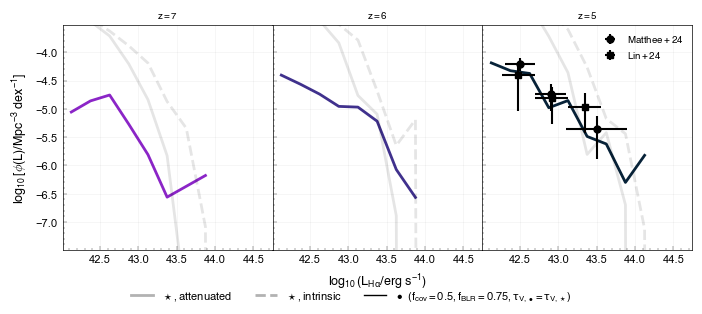

In [27]:

X_limits = [42.01, 44.75]
Y_limits = [-7.49, -3.51]


binw = 0.25
bin_edges = np.arange(42., 44.75, binw)
bin_centres = bin_edges[:-1]+binw/2
nbins = len(bin_centres)

N = 3
left = 0.075
top = 0.95
bottom = 0.2
right = 0.975
# panel_width = (right-left)/N
# panel_height = top-bottom
fig, axes = plt.subplots(1, 3, figsize = (7,3.0), sharey = True, sharex = True)
plt.subplots_adjust(left=left, top=top, bottom=bottom, right=right, wspace=0.0, hspace=0.1)


for z, tag, c, ax in zip(flares.redshifts[-3:], flares.tags[-3:], flares.redshift_colours[-3:], axes.flatten()):

    # add redshift label
    ax.text(0.5, 1.02, rf'$\rm z={z:.0f}$', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize = 7)

    # get quantities for this snapshot
    blackhole_mass, blackhole_accretion_rate, bolometric_luminosity, weights, ionising_photon_luminosity, halpha_luminosity, conservative_selection, stellar_halpha_luminosity, intrinsic_stellar_halpha_luminosity = get_quantities(tag=tag)

    log10fesc = np.log10(stellar_halpha_luminosity) - np.log10(intrinsic_stellar_halpha_luminosity)


    total_number_of_blackholes = len(halpha_luminosity)
    size = int(total_number_of_blackholes * f_blr)
    ntrials = 500
    phi = np.empty((ntrials, nbins))
    N = np.empty((ntrials, nbins))

    for i in range(ntrials):

        fblr_selection = np.random.choice(np.arange(0, total_number_of_blackholes), size=size, replace=False)

        # full selection
        x = np.log10(halpha_luminosity[fblr_selection].to('erg/s').value) + np.log10(f_cov) + log10fesc[fblr_selection]

        N_, _ = np.histogram(x, bins = bin_edges)
        N[i, :] = N_

        Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[fblr_selection])

        Nw[Nw==0.0] = 1E-100

        phi_ = (Nw / flares.volume) / binw
        phi[i, :] = phi_

    robust = np.median(N, axis=0)>2

    median_phi = np.median(phi, axis=0)

    ax.plot(bin_centres[robust], np.log10(median_phi[robust]), c=c, lw=2, zorder=1, ls='-')

    # add stellar LFs
    add_stellar_luminosity_function(ax, tag)

    # add observations
    add_observations(z, ax, add_label=True)

    ax.legend(fontsize=7)
    ax.set_xlim(X_limits)
    ax.set_ylim(Y_limits)




fig.text(0.0, bottom+(top-bottom)/2, r'$\rm\log_{10}[\phi(L)/Mpc^{-3}\ dex^{-1}]$', rotation = 90, va='center', fontsize = 9)
fig.text(left+(right-left)/2, 0.08, r'$\rm \log_{10}(L_{H\alpha}/erg\ s^{-1})$', ha='center', fontsize = 9)


handles = []
handles.append(Line2D([0], [0], label=r'$\rm \star, attenuated$', color='k', lw=2, alpha=0.3, ls='-'))
handles.append(Line2D([0], [0], label=r'$\rm \star, intrinsic$', color='k', lw=2, alpha=0.3, ls='--'))
handles.append(Line2D([0], [0], label=r'$\rm \bullet\ (f_{cov}=0.5, f_{BLR}=0.75, \tau_{V,\bullet}=\tau_{V,\star})$', color='k', lw=1, alpha=1.0, ls='-'))


fig.legend(handles=handles, fontsize=8, labelspacing=0.1, loc = 'outside lower center', ncol=len(handles))

fig.savefig(f'figures/halpha_luminosity_function_evolution.pdf')
plt.show()
fig.clf()
